### Overview of the environment
In this activity, you will use a simple grid environment (5 × 5) in which the agent starts at a random position and must navigate to a goal state while avoiding pitfalls. The environment includes:

States: each cell on the grid is a unique state.

Actions: the agent can move up, down, left, or right.

Rewards:

+10 for reaching the goal state (position 24).

–10 for falling into a pit (position 12).

–1 for all other movements (to encourage faster goal-reaching).

The objective is to compare how each algorithm—Q-learning and policy gradients—handles this environment and analyze their behavior.



### Implement Q-learning
The first part of the activity focuses on Q-learning, a value-based reinforcement learning algorithm.

In [13]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


In [ ]:
# -----------------------------
# 1) GridWorld environment
# -----------------------------
grid_size = 5
n_states = grid_size * grid_size
n_actions = 4  # 0: up, 1: down, 2: left, 3: right

GOAL = 24   # terminal with +10
PIT  = 12   # terminal with -10

# Rewards: default -1 step cost, +10 at GOAL, -10 at PIT
# 生成一个5X5(n_states)的矩阵，里面全部是-1, 表示在每一步（每个状态）默认都会受到 -1 的惩罚，
# 这样智能体会倾向于尽快到达目标（因为每多走一步就多受罚）。
base_rewards = np.full((n_states,), -1.0, dtype=np.float32)
# 这把终点（GOAL 的索引，比如 24）对应的reward 改为 +10 → 当智能体到达目标格子时，获得 +10 奖励。
base_rewards[GOAL] = 10.0
# 这把陷阱（PIT 的索引，比如 12) 对应的reward 改为 -10 → 当智能体掉进陷阱时，受到额外惩罚。
base_rewards[PIT]  = -10.0
"""
[-1, -1, -1, -1, -1,
 -1, -1, -1, -1, -1,
 -1, -1, -10, -1, -1,
 -1, -1, -1, -1, -1,
 -1, -1, -1, -1, +10]
"""

# 把线性编号（0～24）转换为网格坐标 (行, 列)
"""
idx2rc(12)  # -> (2, 2)
idx2rc(24)  # -> (4, 4)
"""
def idx2rc(idx):
    """Convert linear index to (row, col)."""
    return divmod(idx, grid_size)

def rc2idx(r, c):
    """Convert (row, col) to linear index."""
    return r * grid_size + c

def step(state, action):
    """
    Deterministic transition:
    - Move within grid boundaries.
    - Terminal at GOAL or PIT (episode ends).
    Returns: next_state, reward, done
    """
    if state in (GOAL, PIT):
        return state, 0.0, True

    r, c = idx2rc(state)
    if action == 0:   # up
        r = max(0, r - 1)
    elif action == 1: # down
        r = min(grid_size - 1, r + 1)
    elif action == 2: # left
        c = max(0, c - 1)
    elif action == 3: # right
        c = min(grid_size - 1, c + 1)

    next_state = rc2idx(r, c)
    reward = float(base_rewards[next_state])
    done = next_state in (GOAL, PIT)
    return next_state, reward, done

def reset():
    """Start from a random non-terminal state."""
    while True:
        s = np.random.randint(0, n_states)
        if s not in (GOAL, PIT):
            return s

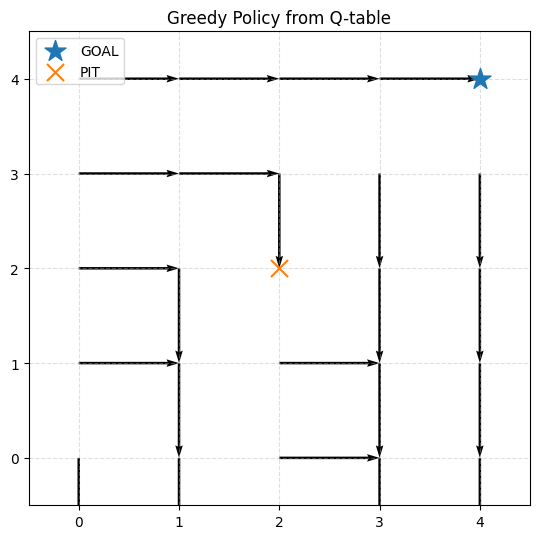

In [19]:
# -----------------------------
# 2) Q-Learning
# -----------------------------
alpha  = 0.1   # learning rate
gamma  = 0.99  # discount
epsilon_start = 0.2
epsilon_end   = 0.01
epsilon_decay_episodes = 800

Q = np.zeros((n_states, n_actions), dtype=np.float32)

def epsilon_greedy_action(Q, state, epsilon):
    """Epsilon-greedy action selection."""
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    return int(np.argmax(Q[state]))

qlearning_episodes = 1000
max_steps_per_episode = 200
rewards_q_learning = []

for ep in range(qlearning_episodes):
    # Linear epsilon decay
    epsilon = max(
        epsilon_end,
        epsilon_start - (epsilon_start - epsilon_end) * (ep / max(1, epsilon_decay_episodes))
    )

    s = reset()
    done = False
    ep_reward = 0.0
    steps = 0

    while not done and steps < max_steps_per_episode:
        a = epsilon_greedy_action(Q, s, epsilon)
        ns, r, done = step(s, a)

        # Q-learning update (Bellman optimality)
        td_target = r + (0.0 if done else gamma * np.max(Q[ns]))
        Q[s, a] += alpha * (td_target - Q[s, a])

        s = ns
        ep_reward += r
        steps += 1

    rewards_q_learning.append(ep_reward)

import matplotlib.pyplot as plt
import numpy as np

# 把每个 state 的“最优动作”转换为向量
# 动作：0:up, 1:down, 2:left, 3:right
vec = {
    0: (-1, 0),  # up:    Δrow=-1, Δcol=0
    1: ( 1, 0),  # down
    2: ( 0,-1),  # left
    3: ( 0, 1),  # right
}

# 网格坐标（行→y，列→x）
Y, X = np.mgrid[0:grid_size, 0:grid_size]
U = np.zeros_like(X, dtype=float)  # x 方向
V = np.zeros_like(Y, dtype=float)  # y 方向（注意画图坐标和行列方向可能相反）

for s in range(n_states):
    r, c = divmod(s, grid_size)
    if s in (GOAL, PIT):
        U[r, c] = 0
        V[r, c] = 0
    else:
        a = int(np.argmax(Q[s]))
        dr, dc = vec[a]
        # 画图坐标中：x 对应列增量 dc，y 对应行增量 dr
        U[r, c] = dc
        V[r, c] = -dr   # 行向下是正，画图里向上是正，所以取负号

plt.figure(figsize=(5.5,5.5))
plt.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=1, width=0.005)

# 标出 GOAL / PIT
gr, gc = divmod(GOAL, grid_size)
pr, pc = divmod(PIT,  grid_size)
plt.scatter([gc],[gr], s=250, marker='*', label='GOAL', zorder=3)
plt.scatter([pc],[pr], s=150, marker='x', label='PIT',  zorder=3)

# 美化：网格线 & 坐标范围
plt.gca().invert_yaxis()                           # 使 (0,0) 在左上角，符合“行从上到下”的直觉
plt.xticks(range(grid_size)); plt.yticks(range(grid_size))
plt.grid(True, linestyle='--', alpha=0.4)
plt.xlim(-0.5, grid_size-0.5); plt.ylim(-0.5, grid_size-0.5)
plt.title('Greedy Policy from Q-table')
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
# -----------------------------
# 3) Policy Gradient (REINFORCE)
# -----------------------------
# Policy network: softmax over actions given one-hot state
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(n_states,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_actions, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

def select_action(state_idx):
    """Sample an action from the policy π(a|s)."""
    state_oh = tf.one_hot(state_idx, n_states)[tf.newaxis, ...]  # (1, n_states)
    action_probs = model(state_oh).numpy()[0]                    # (n_actions,)
    return np.random.choice(n_actions, p=action_probs)

def compute_returns(rewards, gamma=0.99):
    """Compute discounted returns G_t for a single episode."""
    G = np.zeros_like(rewards, dtype=np.float32)
    running = 0.0
    for t in reversed(range(len(rewards))):
        running = rewards[t] + gamma * running
        G[t] = running
    # Optional: normalize for variance reduction
    if len(G) > 1:
        G = (G - G.mean()) / (G.std() + 1e-8)
    return G

def update_policy(states, actions, rewards):
    """REINFORCE: ∇θ J = E[∑ G_t ∇θ log πθ(a_t|s_t)]."""
    returns = compute_returns(rewards, gamma=0.99)

    with tf.GradientTape() as tape:
        state_inputs = tf.one_hot(states, n_states)        # (T, n_states)
        action_probs = model(state_inputs)                 # (T, n_actions)
        action_masks = tf.one_hot(actions, n_actions)      # (T, n_actions)
        log_probs = tf.reduce_sum(action_masks * tf.math.log(action_probs + 1e-8), axis=1)  # (T,)
        loss = -tf.reduce_mean(log_probs * returns)        # maximize returns → minimize negative

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

pg_episodes = 1000
rewards_policy_gradients = []

for ep in range(pg_episodes):
    s = reset()
    done = False
    ep_states, ep_actions, ep_rewards = [], [], []
    steps = 0

    while not done and steps < max_steps_per_episode:
        a = select_action(s)
        ns, r, done = step(s, a)

        ep_states.append(s)
        ep_actions.append(a)
        ep_rewards.append(r)

        s = ns
        steps += 1

    # One policy update per episode
    update_policy(ep_states, ep_actions, ep_rewards)
    rewards_policy_gradients.append(sum(ep_rewards))

### Step 1: Initialize the Q-table
Initialize the Q-table to store the Q-values for each state-action pair. This table will be updated as the agent explores the environment and learns which actions yield the highest rewards.

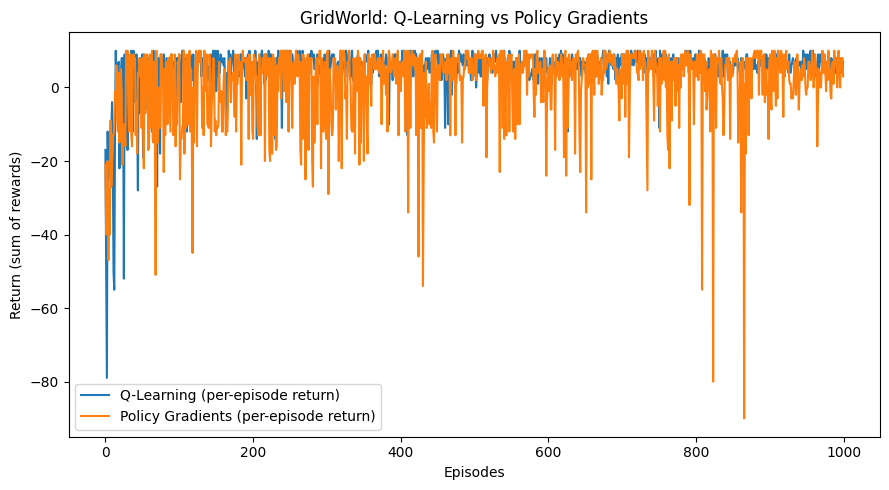

In [17]:
# -----------------------------
# 4) Visualization
# -----------------------------
plt.figure(figsize=(9, 5))
plt.plot(rewards_q_learning, label='Q-Learning (per-episode return)')
plt.plot(rewards_policy_gradients, label='Policy Gradients (per-episode return)')
plt.xlabel('Episodes')
plt.ylabel('Return (sum of rewards)')
plt.title('GridWorld: Q-Learning vs Policy Gradients')
plt.legend()
plt.tight_layout()
plt.show()

### Implement policy gradients

The second part of the activity involves implementing policy gradients, a policy-based method in which the agent learns a policy (mapping from states to actions) by optimizing a neural network.

### Step-by-step guide:

#### Step 1: Build the policy network
Define a neural network that takes the current state as input and then outputs a probability distribution over possible actions.

In [7]:
import tensorflow as tf

# Define the policy network
n_states = grid_size * grid_size  # Number of states in the grid
n_actions = 4  # Up, down, left, right

model = tf.keras.Sequential([
    tf.keras.layers.Dense(24, activation='relu', input_shape=(n_states,)),
    tf.keras.layers.Dense(n_actions, activation='softmax')  # Output action probabilities
])

# Optimizer for policy network updates
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

/Users/isdance/Desktop/projects/coursera-microsoft-ml-ai/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Step 2: Select an action
For each state, the agent selects an action based on the probabilities output by the policy network.

In [8]:
def get_action(state):
    state_input = tf.one_hot(state, n_states)  # One-hot encoding for state
    action_probs = model(state_input[np.newaxis, :])
    return np.random.choice(n_actions, p=action_probs.numpy()[0])

### Step 3: Simulate the environment
Simulate the environment as the agent selects actions and collects rewards.

In [9]:
# Simulation loop
states = []
actions = []
episode_rewards = []  

for episode in range(1000):
    state = np.random.randint(0, n_states)  # Start in a random state
    done = False
    while not done:
        action = get_action(state)  # Use the provided function
        next_state = np.random.randint(0, n_states)  # Simulated next state
        reward = rewards[next_state]  

        # Store the state-action-reward trajectory
        states.append(state)
        actions.append(action)
        episode_rewards.append(reward)  

        state = next_state
        if next_state in {24, 12}:  
            done = True

### Step 4: Compute cumulative rewards
To reinforce actions that lead to long-term success, calculate the cumulative rewards for each action taken during an episode.

In [10]:
def compute_cumulative_rewards(rewards, gamma=0.99):
    cumulative_rewards = np.zeros_like(rewards)
    running_add = 0
    for t in reversed(range(len(rewards))):
        running_add = running_add * gamma + rewards[t]
        cumulative_rewards[t] = running_add
    return cumulative_rewards

### Step 5: Update the policy
Update the policy network using the REINFORCE algorithm based on the actions and cumulative rewards.

In [11]:
def update_policy(states, actions, rewards):
    cumulative_rewards = compute_cumulative_rewards(rewards)

    with tf.GradientTape() as tape:
        state_inputs = tf.one_hot(states, n_states)  # Convert states to one-hot encoding
        action_probs = model(state_inputs)
        action_masks = tf.one_hot(actions, n_actions)  # Mask for selected actions
        log_probs = tf.reduce_sum(action_masks * tf.math.log(action_probs), axis=1)

        # Policy loss is the negative log-probability of the action times the cumulative reward
        loss = -tf.reduce_mean(log_probs * cumulative_rewards)

    # Apply gradients to update the policy network
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

### Comparison and analysis
After implementing both Q-learning and policy gradients, it’s time to compare their performance. Here’s what to consider:

Convergence speed: how quickly does each algorithm learn an optimal policy?

1. Reward maximization: which algorithm achieves higher cumulative rewards?
2. Exploration vs. exploitation: how do Q-learning and policy gradients handle exploration of the environment?
3. Suitability: which algorithm is better suited for this environment, and why?
4. Use Matplotlib to visualize the cumulative rewards over episodes and compare how each algorithm performs.

In [12]:
import matplotlib.pyplot as plt

# Example code to visualize rewards over episodes
plt.plot(rewards_q_learning, label='Q-Learning')
plt.plot(rewards_policy_gradients, label='Policy Gradients')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Rewards')
plt.legend()
plt.show()

NameError: name 'rewards_q_learning' is not defined